# Informazioni consegna
* Aggiungere i componenti del proprio gruppo in questo [form](https://forms.office.com/r/1WKBx4YgSH). 
* **I gruppi possono essere composti da massimo 3 persone. Nel caso si intenda fare il progetto da soli bisogna comunque aggiungere il proprio nome nel form.**
* Per la consegna è necessario caricare su Virtuale la relazione, il notebook Colab e le immagini generate.
* La consegna deve essere effettuata da un qualsiasi membro del gruppo e verrà automaticamente attribuita ai restanti componenti.
* Per i dettagli sulle tempistiche e le scadenze si faccia riferimento a Virtuale.

# Deblur Immagini
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:

\begin{align*}
    b = A x + \eta
\end{align*}

dove $b$ rappresenta l'immagine corrotta, $x$ l'immagine originale che vogliamo ricostruire, $A$ l'operatore che applica il blur Gaussiano ed $\eta$ il rumore additivo con distribuzione Gaussiana di  media $\mathbb{0}$ e deviazione standard $\sigma$.

## Funzioni di blur
Le seguenti funzioni servono per applicare il blur di tipo gaussiano ad un'immagine.



In [40]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft
from scipy.optimize import minimize

# Create a Gaussian kernel of size kernlen and standard deviation sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Unidimensional Gaussian kernel
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Bidimensional Gaussian kernel
    kern2d = np.outer(kern1d, kern1d)
    # Normalization
    return kern2d / kern2d.sum()

# Compute the FFT of the kernel 'K' of size 'd' padding with the zeros necessary
# to match the size of 'shape'
def psf_fft(K, d, shape):
    # Zero padding
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Shift
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Compute FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Multiplication by A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Multiplication by A transpose
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

## Generazione dataset
Generare un set di 8 immagini 512 $\times$ 512 in formato ${\tt png}$ in scala dei grigi che contengano tra i 2 ed i 6 oggetti geometrici, di colore uniforme, su sfondo nero. 


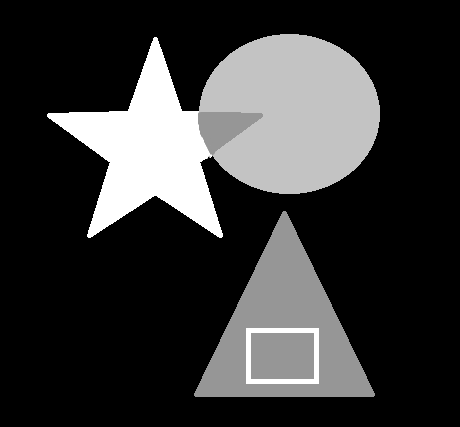


## 1) Generazione immagini corrotte
Degradare le immagini applicando, mediante le funzioni riportate nella cella precedente,  l'operatore di blur con parametri

+ $\sigma=0.5$ dimensione $5\times 5$
+ $\sigma=1$ dimensione $7\times 7$
+ $\sigma=1.3$ dimensione $9\times 9$

ed aggiungendo rumore gaussiano con deviazione standard $(0,0.05]$

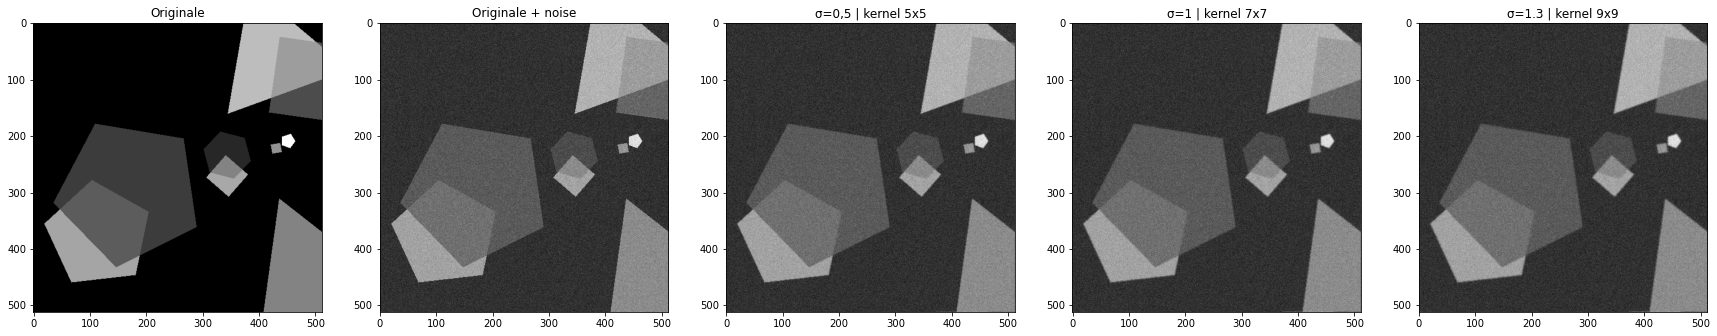

In [41]:
def gaussian_blur(image_size, kernel_len, sigma): 
    return psf_fft(gaussian_kernel(kernel_len, sigma), kernel_len, image_size)

# real_image = data.camera().astype(np.float64) / 255.0
real_image = plt.imread("./dataset/test.png").astype(np.float64)

# Filtro blur (A)
blur1 = gaussian_blur(real_image.shape, 5, 0.5)
blur2 = gaussian_blur(real_image.shape, 7, 1)
blur3 = gaussian_blur(real_image.shape, 9, 1.3)

# Filtro rumore (η)
dev = 0.05
noise = np.random.normal(size=real_image.shape) * dev

image1 = A(real_image, blur1) + noise
image2 = A(real_image, blur2) + noise
image3 = A(real_image, blur3) + noise

real_noisy = real_image + noise


plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 5, 1)
ax1.imshow(real_image, cmap="gray")
plt.title("Originale")

ax1 = plt.subplot(1, 5, 2)
ax1.imshow(real_noisy, cmap="gray")
plt.title("Originale + noise")

ax2 = plt.subplot(1, 5, 3)
ax2.imshow(image1, cmap="gray")
plt.title("σ=0,5 | kernel 5x5")

ax3 = plt.subplot(1, 5, 4)
ax3.imshow(image2, cmap="gray")
plt.title("σ=1 | kernel 7x7")

ax4 = plt.subplot(1, 5, 5)
ax4.imshow(image3, cmap="gray")
plt.title("σ=1.3 | kernel 9x9")

plt.show()

## 2) Soluzione naive

Una possibile ricostruzione dell'immagine originale $x$ partendo dall'immagine corrotta $b$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:
\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2
\end{align}

La funzione $f$ da minimizzare è data dalla formula
  $f(x) = \frac{1}{2} ||Ax - b||_2^2 $, il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb  $.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` calcolare la soluzione naive. 

In [42]:
def deblur_naive(image, blur):
    def f(x): 
        x = x.reshape(image.shape)
        return ((1/2) * (np.linalg.norm(A(x, blur) - image))**2).reshape(-1)
    def df(x):
        x = x.reshape(image.shape)
        return (AT(A(x, blur), blur) - AT(image, blur)).reshape(-1)

    out = minimize(
        fun = f, 
        x0 = np.zeros(image.reshape(-1).shape),
        method = "CG",
        jac = df
    )

    return out


## 3) Regolarizzazione
Per ridurre gli effetti del rumore nella ricostruzione è necessario introdurre un termine di regolarizzazione di Tikhonov. Si considera quindi il seguente problema di ottimizzazione.
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2
\end{align*}

La funzione $f$ da minimizzare diventa
$f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2$
il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb + λx$.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` ed il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 

In [43]:
def deblur_tikhonov(image, blur, lamb):
    def f(x): 
        x = x.reshape(image.shape)
        return ((((1/2) * (np.linalg.norm(A(x, blur) - image))**2 + ((lamb/2)) * (np.linalg.norm(x))**2)).reshape(-1)) 
    def df(x):
        x = x.reshape(image.shape)
        return (AT(A(x, blur), blur) - AT(image, blur) + (lamb * x)).reshape(-1)

    out = minimize(
        fun = f, 
        x0 = np.zeros(image.reshape(-1).shape),
        method = "CG",
        jac = df
    )

    return out

In [44]:
eps = 1e-2

def next_step(f, x, grad):  # backtracking procedure for the choice of the steplength
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  p = -grad
  j = 0
  jmax = 10
  while ((f(x+alpha*p) > f(x) + c1 * alpha * grad.T @ p) and j < jmax):
    alpha = rho * alpha
    j += 1
  if (j > jmax):
    return -1
  else:
    return alpha

def gradiente(f, grad_f, x0, step, MAXITERATION, ABSOLUTE_STOP):
  # initialize first values
  x_last = np.array(x0)
  
  k = 0
  while (np.linalg.norm(grad_f(x_last)) > ABSOLUTE_STOP and k < MAXITERATION ):
    k = k+1
    grad = grad_f(x_last)

    # backtracking step
    step = next_step(f, x_last, grad)
    
    if (step == -1):
      print('non convergente')
      return (k) # no convergence

    x_last= x_last - step*grad
 
  return (x_last, k)

def deblur_tikhonov2(image, blur, lamb):
  def f(x):
      x = x.reshape(image.shape)
      return ((((1 / 2) * (np.linalg.norm(A(x, blur) - image))**2 + ((lamb / 2)) * (np.linalg.norm(x))**2)).reshape(-1))

  def df(x):
      x = x.reshape(image.shape)
      return (AT(A(x, blur), blur) - AT(image, blur) + (lamb * x)).reshape(-1)

  x0 = np.zeros(image.reshape(-1).shape)
  return gradiente(
      f = f,
      grad_f = df,
      x0 = x0,
      step = next_step(f, x0, df(x0)),
      MAXITERATION=1000,
      ABSOLUTE_STOP = 1.e-5
  )


## 4) Variazione Totale (Facoltativo) 

Un'altra funzione adatta come termine di regolarizzazione è la Variazione Totale. Data $u$ immagine di dimensioni $m\times n$ la variazione totale $TV$ di $u$ è definit come:
\begin{align*}
  TV(u) = \sum_i^n{\sum_j^m{\sqrt{||\nabla u(i, j)||_2^2 + \epsilon^2}}}
\end{align*}
Per calcolare il gradiente dell'immagine $\nabla u$ usiamo la funzione `np.gradient` che approssima la derivata per ogni pixel calcolando la differenza tra pixel adiacenti. I risultati sono due immagini della stessa dimensione dell'immagine in input, una che rappresenta il valore della derivata orizzontale `dx` e l'altra della derivata verticale `dy`. Il gradiente dell'immagine nel punto $(i, j)$ è quindi un vettore di due componenti, uno orizzontale contenuto in `dx` e uno verticale in `dy`.

Come nei casi precedenti il problema di minimo che si va a risolvere è il seguente:
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda TV(u)
\end{align*}
il cui gradiente $\nabla f$ è dato da
\begin{align*}
\nabla f(x) = (A^TAx - A^Tb)  + \lambda \nabla TV(x)
\end{align*}

Utilizzando il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 


---
Per risolvere il problema di minimo è necessario anche calcolare il gradiente della variazione totale che è definito nel modo seguente
\begin{align*}
  \nabla TV(u) = -div\left(\frac{\nabla u}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}\right)
\end{align*}

\begin{align*}
  div(F) = \frac{\partial F_x}{\partial x} + \frac{\partial F_y}{\partial y}
\end{align*}

$div(F)$ è la divergenza del campo vettoriale $F$, nel nostro caso $F$ ha due componenti dati dal gradiente dell'immagine $\nabla u$ scalato per il valore $ \frac{1}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}$. Per calcolare la divergenza bisogna calcolare la derivata orizzontale $\frac{\partial F_x}{\partial x}$ della componente $x$ di $F$ e sommarla alla derivata verticale $\frac{\partial F_y}{\partial y}$ della componente $y$ di $F$. Per specificare in quale direzione calcolare la derivata con la funzione `np.gradient` utilizziamo il parametro `axis = 0` per l'orizzontale e `axis = 1` per la verticale.

In [45]:
# Variazione totale
def totvar(x):
  # Calcola il gradiente di x
  dx, dy = np.gradient(x)
  n2 = np.square(dx) + np.square(dy)

  # Calcola la variazione totale di x
  tv = np.sqrt(n2 + eps**2).sum()
  return tv

# Gradiente della variazione totale
def grad_totvar(x):
  # Calcola il numeratore della frazione
  dx, dy = np.gradient(x)

  # Calcola il denominatore della frazione
  n2 = np.square(dx) + np.square(dy)
  den = np.sqrt(n2 + eps**2)

  # Calcola le due componenti di F dividendo il gradiente per il denominatore
  Fx = dx / den
  Fy = dy / den

  # Calcola la derivata orizzontale di Fx 
  dFdx = np.gradient(Fx, axis=0)
  
  # Calcola la derivata verticale di Fy
  dFdy = np.gradient(Fy, axis=1)

  # Calcola la divergenza 
  div = (dFdx + dFdy)

  # Restituisci il valore del gradiente della variazione totale
  return -div

In [46]:
def deblur_tv(image, blur, lamb):
    def f(x):
        x = x.reshape(image.shape)
        return ((((1 / 2) * (np.linalg.norm(A(x, blur) - image))**2 + ((lamb/2)) * totvar(x))).reshape(-1))

    def df(x):
        x = x.reshape(image.shape)
        return (AT(A(x, blur), blur) - AT(image, blur) + (lamb * grad_totvar(x))).reshape(-1)

    out = minimize(
        fun=f,
        x0=np.zeros(image.reshape(-1).shape),
        method="CG",
        jac=df
    )

    return out

In [67]:
curr_image = image1

out_naive = deblur_naive(curr_image, blur1)
out_tikhonov = deblur_tikhonov(curr_image, blur1, 0.5)
out_tikhonov2, n_it = deblur_tikhonov2(curr_image, blur1, 0.5)
out_tv = deblur_tv(curr_image, blur1, 0.02)


In [64]:
out_naive = out_naive.x.reshape(curr_image.shape)
out_tikhonov = out_tikhonov.x.reshape(curr_image.shape)
out_tikhonov2 = out_tikhonov2.reshape(curr_image.shape)
out_tv = out_tv.x.reshape(curr_image.shape)


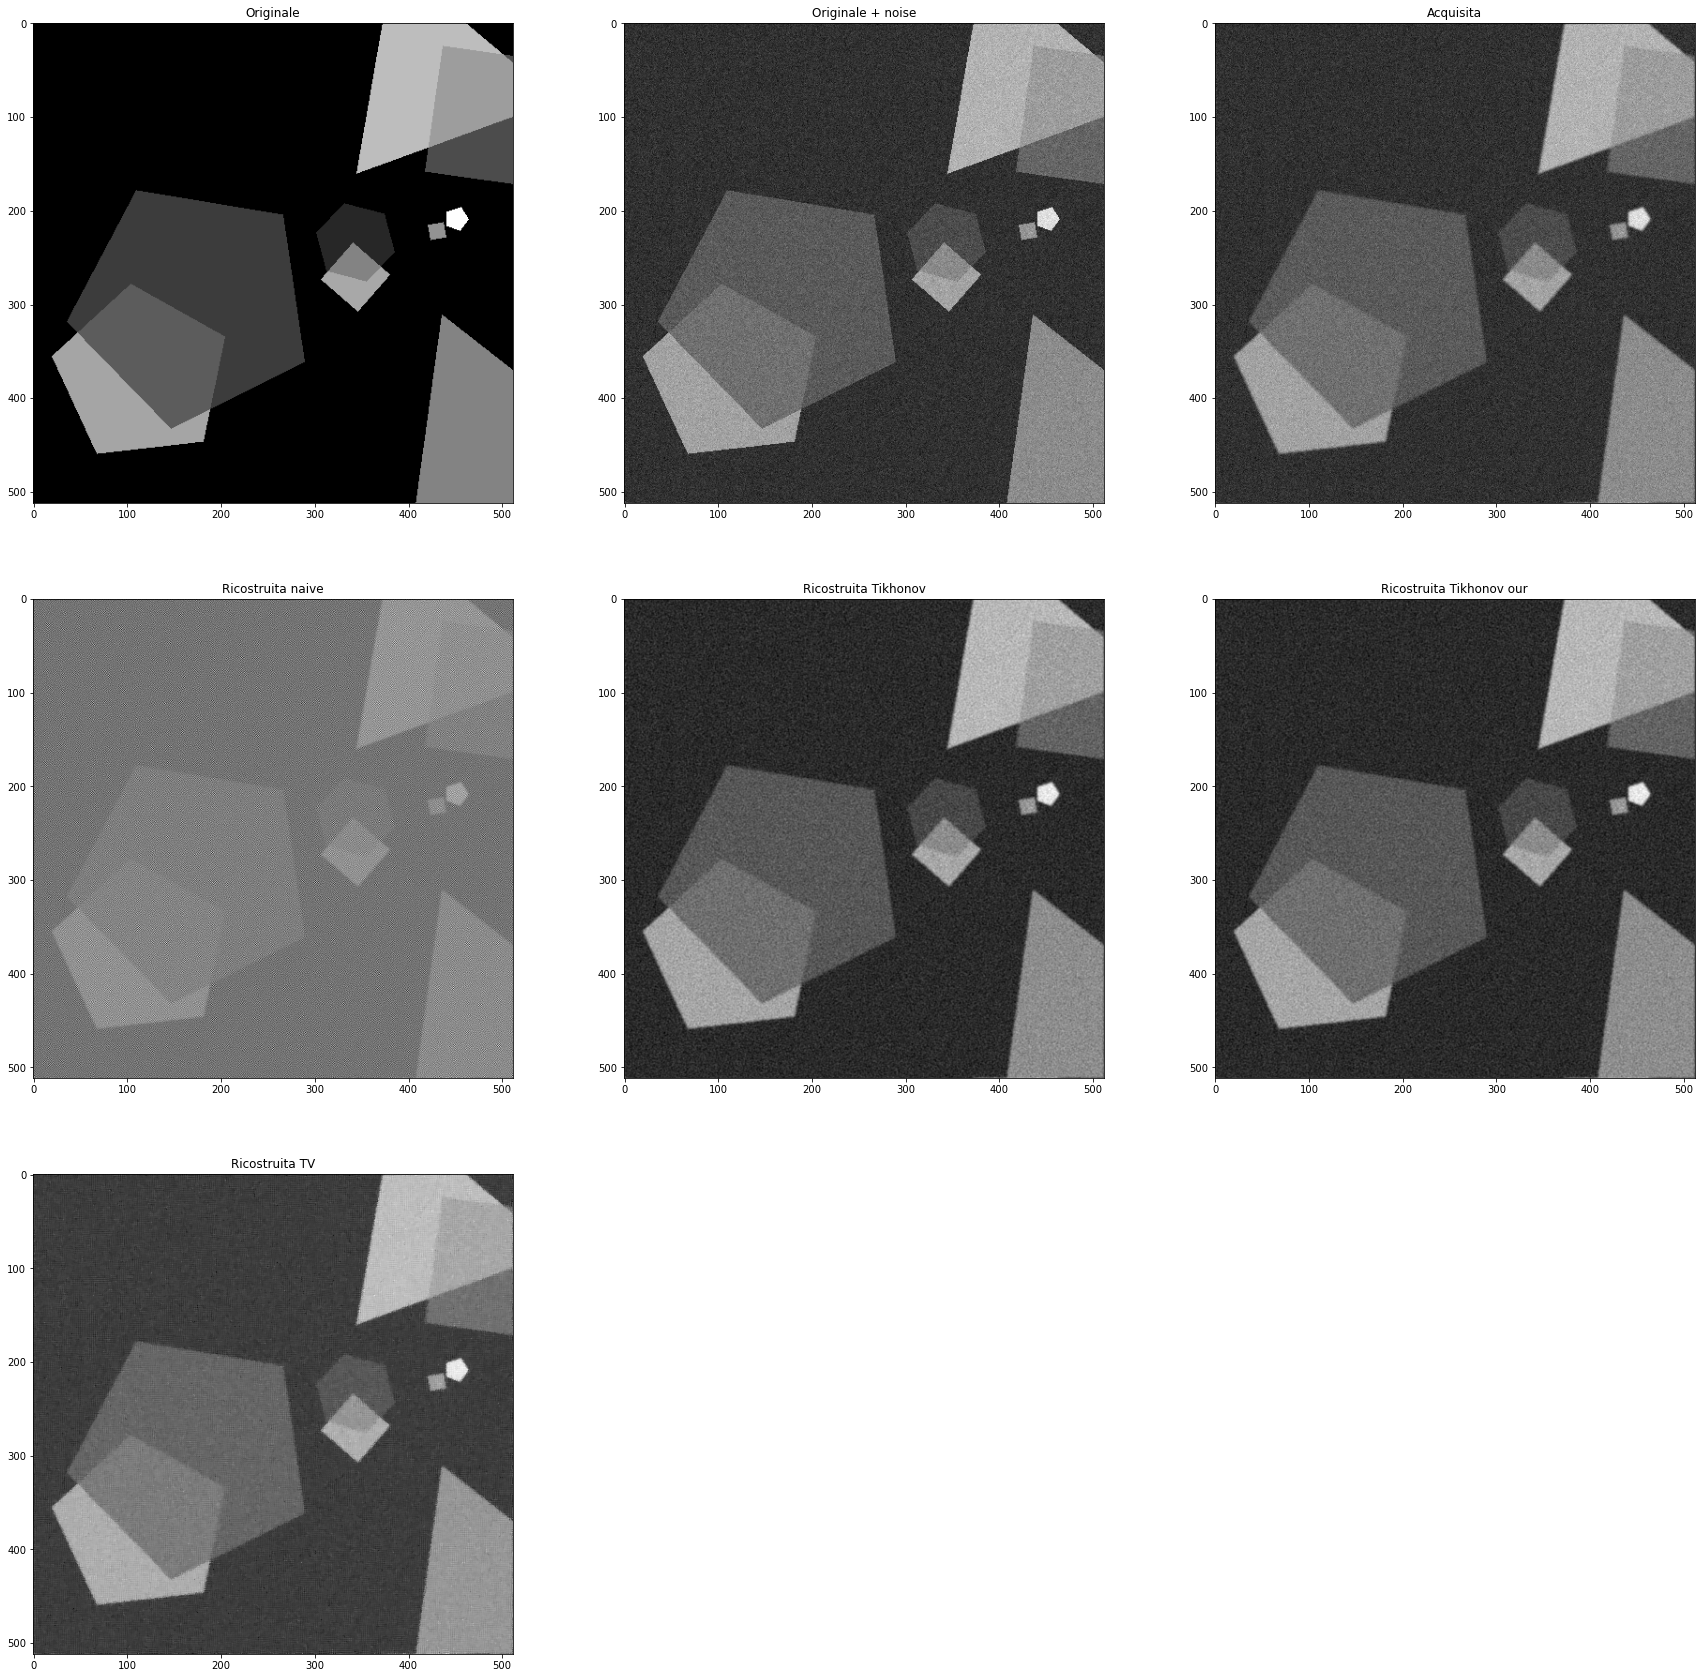

In [65]:
plt.figure(figsize=(30, 30))

ax1 = plt.subplot(3, 3, 1)
ax1.imshow(real_image, cmap="gray")
plt.title("Originale")

ax1 = plt.subplot(3, 3, 2)
ax1.imshow(real_noisy, cmap="gray")
plt.title("Originale + noise")

ax2 = plt.subplot(3, 3, 3)
ax2.imshow(curr_image, cmap="gray")
plt.title("Acquisita")

ax3 = plt.subplot(3, 3, 4)
ax3.imshow(out_naive, cmap="gray")
plt.title("Ricostruita naive")

ax3 = plt.subplot(3, 3, 5)
ax3.imshow(out_tikhonov, cmap="gray")
plt.title("Ricostruita Tikhonov")

ax3 = plt.subplot(3, 3, 6)
ax3.imshow(out_tikhonov2, cmap="gray")
plt.title("Ricostruita Tikhonov our")

ax3 = plt.subplot(3, 3, 7)
ax3.imshow(out_tv, cmap="gray")
plt.title("Ricostruita TV")

plt.show()


In [66]:
print("MSE originale/ricostruita \t\t", metrics.mean_squared_error(real_image, curr_image))
print("MSE originale/naive \t\t\t", metrics.mean_squared_error(real_image, out_naive))
print("MSE originale/Tikhonov1 \t\t", metrics.mean_squared_error(real_image, out_tikhonov))
print("MSE originale/Tikhonov2 \t\t", metrics.mean_squared_error(real_image, out_tikhonov2))
print("MSE originale/Variazione totale \t", metrics.mean_squared_error(real_image, out_tv))

print()

print("PSNR originale/ricostruita \t\t", metrics.peak_signal_noise_ratio(real_image, curr_image))
print("PSNR originale/naive \t\t\t", metrics.peak_signal_noise_ratio(real_image, out_naive))
print("PSNR originale/Tikhonov1 \t\t", metrics.peak_signal_noise_ratio(real_image, out_tikhonov))
print("PSNR originale/Tikhonov2 \t\t", metrics.peak_signal_noise_ratio(real_image, out_tikhonov2))
print("PSNR originale/Variazione totale \t", metrics.peak_signal_noise_ratio(real_image, out_tv))

MSE originale/ricostruita 		 0.0028979173829379325
MSE originale/naive 			 0.20371454959254234
MSE originale/Tikhonov1 		 0.006504886522904356
MSE originale/Tikhonov2 		 0.006504859142906776
MSE originale/Variazione totale 	 0.001169760796395361

PSNR originale/ricostruita 		 25.379140000400056
PSNR originale/naive 			 6.909779519419054
PSNR originale/Tikhonov1 		 21.867602752601695
PSNR originale/Tikhonov2 		 21.867621032715952
PSNR originale/Variazione totale 	 29.319029377636582


<table>
<tr>

<td>
MSE originale/ricostruita 		    0.002692015184601925<br/>
MSE originale/naive 			    0.20344099852157485<br/>
MSE originale/Tikhonov1 		    0.006295764584527871<br/>
MSE originale/Tikhonov2 		    0.006295750038869333<br/>
MSE originale/Variazione totale 	0.000668919274743792<br/>
<br/>
PSNR originale/ricostruita 		    25.699224947562975<br/>
PSNR originale/naive 			    6.915615212390237<br/>
PSNR originale/Tikhonov1 		    22.009515197773247<br/>
PSNR originale/Tikhonov2 		    22.00952523167215<br/>
PSNR originale/Variazione totale 	31.746262897787695<br/>
</td>

<td>
MSE originale/ricostruita 		 0.002837512754693729<br/>
MSE originale/naive 			 0.20362652243345203<br/>
MSE originale/Tikhonov1 		 0.006438070352908622<br/>
MSE originale/Tikhonov2 		 0.0064380456038719116<br/>
MSE originale/Variazione totale 	 0.001083478980981092<br/>
<br/>
PSNR originale/ricostruita 		 25.470621776294273<br/>
PSNR originale/naive 			 6.9116565562646395<br/>
PSNR originale/Tikhonov1 		 21.912442818111604<br/>
PSNR originale/Tikhonov2 		 21.912459513161746<br/>
PSNR originale/Variazione totale 	 29.651795093856677<br/>
</td>

<td>
MSE originale/ricostruita 		 0.0028979173829379325<br/>
MSE originale/naive 			 0.20371454959254234<br/>
MSE originale/Tikhonov1 		 0.006504886522904356<br/>
MSE originale/Tikhonov2 		 0.006504859142906776<br/>
MSE originale/Variazione totale 	 0.001169760796395361<br/>
<br/>
PSNR originale/ricostruita 		 25.379140000400056<br/>
PSNR originale/naive 			 6.909779519419054<br/>
PSNR originale/Tikhonov1 		 21.867602752601695<br/>
PSNR originale/Tikhonov2 		 21.867621032715952<br/>
PSNR originale/Variazione totale 	 29.319029377636582<br/>
</td>

</tr>
</table>

In [ ]:

"""

TODO
- Graficare gli errori al variare di lambda
- Graficare l'errore progressivo

"""


# Relazione

1.   Riportare e commentare i risultati ottenuti nei punti 2. 3. (e 4.) su un immagine del set creato e su altre due immagini in bianco e nero  (fotografiche/mediche/astronomiche)
2.   Riportare delle tabelle con le misure di PSNR e MSE ottenute al variare dei parametri (dimensione kernel, valore di sigma, la deviazione standard del rumore, il parametro di regolarizzazione). 
3. Calcolare sull’intero set di immagini medie e deviazione standard delle metriche per alcuni valori fissati dei parametri.  
4. Analizzare su 2 esecuzioni le proprietà dei metodi numerici utilizzati (gradiente coniugato e gradiente) in termini di numero di iterazioni, andamento dell’errore, della funzione obiettivo, norma del gradiente. 

